## Assignment 6 - text classification using deep learning 

In class this week, we've seen how deep learning models like CNNs can be used for text classification purposes. For your assignment this week, I want you to see how successfully you can use these kind of models to classify a specific kind of cultural data - scripts from the TV series Game of Thrones.

In particular, I want you to see how accurately you can model the relationship between each season and the lines spoken. That is to say - can you predict which season a line comes from? Or to phrase that another way, is dialogue a good predictor of season?

Start by making a baseline using a 'classical' ML solution such as CountVectorization + LogisticRegression and use this as a means of evaluating how well your model performs. Then you should try to come up with a solution which uses a DL model, such as the CNNs we went over in class.

__A 'classical' ML solution such as CountVectorization + LogisticRegression__

Import packages 

In [186]:
# system tools
import os
import sys
sys.path.append(os.path.join(".."))

# data munging tools
import pandas as pd
import numpy as np
from itertools import repeat
import itertools

# Machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

Functions

In [202]:
# Show the most informative features
def show_features(vectorizer, training_labels, classifier, n=20):
    """
    Return the most informative features from a classifier, i.e. the 'strongest' predictors.
    
    vectorizer:
        A vectorizer defined by the user, e.g. 'CountVectorizer'
    classifier:
        A classifier defined by the user, e.g. 'MultinomialNB'
    n:
        Number of features to display, defaults to 20
        
    """
    # Get feature names and coefficients
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(classifier.coef_[0], feature_names))
    # Get ordered labels
    labels = sorted(set(training_labels))
    # Select top n results, where n is function argument
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    # Pretty print columns showing most informative features
    print(f"{labels[0]}\t\t\t\t{labels[1]}\n")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        for (coef_1, fn_1), (coef_2, fn_2) in top:
            print("%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

    return None

# Balance data 
"""
Function to balance data.
dataframe = df to be balanced
colname = column with labels the data should be balanced according to
n = row per label
"""
def balance(dataframe, colname, n=500):

    # Use pandas select a random bunch of examples from each label
    out = (dataframe.groupby(colname, as_index=False)
            .apply(lambda x: x.sample(n=n))
            .reset_index(drop=True))
    
    return out




Reading in the data

In [188]:
# Read the data as 'DATA' from the data folder
filename = os.path.join("data", "Game_of_Thrones_Script.csv")
DATA = pd.read_csv(filename, index_col=0)

In [189]:
#inspect the data 
DATA.sample(10)

,Season,Episode,Episode Title,Name,Sentence
Release Date,,,,,
2013-04-28,Season 3,Episode 5,Kissed by Fire,tyrion lannister,I understand that.
2015-04-26,Season 5,Episode 3,High Sparrow,black haired prostitute,Of course you can. You're shy.
2014-04-13,Season 4,Episode 2,The Lion and the Rose,melisandre,And it frightened you?
2017-07-30,Season 7,Episode 3,The Queen’s Justice,jon snow,Am I your prisoner?
2019-04-14,Season 8,Episode 1,Winterfell,qyburn,"Your Grace, I'm afraid I bring terrible news. ..."
2015-05-17,Season 5,Episode 6,"Unbowed, Unbent, Unbroken",cersei lannister,The King's orders. Is the King to blame for Se...
2017-08-27,Season 7,Episode 7,The Dragon and the Wolf,jaime lannister,Two.
2013-04-14,Season 3,Episode 3,Walk of Punishment,brienne,You were armed when we were taken.
2014-04-13,Season 4,Episode 2,The Lion and the Rose,jaime lannister,Oh!


Create balanced data - sample 1466 from each season (as 1466 is the amount of lines in the season with fewest)

__Preprocess the data__ <br> In order to do an appropriate vectorisation, I need to bundle together multiple lines. Some of them are simply way too short. For each season, have bundle of multiple words then vectorised.

In [190]:
# Get a list of uniques seasons (1 to 8)
seasons = DATA.Season.unique()

# Create empty list to save text chunks and corresponding labels
text = []
labels = []

In [191]:
# Loop over every season and chunk 20 lines together + save season label.
for i in seasons:
    
    # Get data from season
    season = DATA[DATA["Season"] == i]  
    
    # Get lines
    sentences = season["Sentence"]
    
    # Chunk 30 lines together
    chunks = []
    for w in range(0, len(sentences), 30):
        chunks.append(' '.join(sentences[w:w+30]))
    
    # Save to lists outside the loop
    labels.extend(repeat(i, len(chunks)))
    text.append(chunks)

# From list of lists --> to list
text = list(itertools.chain(*text))

Balance the data 
- I need to store the lists as a df in order to use the balance function

In [192]:
df = pd.DataFrame()
df["season"] = labels
df["line_chunks"] = text

# Get the minimum amount of line chunks for a season - balance accordingly
min_count = df["season"].value_counts().min()

# Use predefined balance() function to balance amount of entrances across seasons
balanced = balance(df, "season", min_count)

# Extract information from the df
line_chunks = balanced["line_chunks"]
season = balanced["season"]

Train-test split

In [193]:
# Split the data in train and test.
X_train, X_test, y_train, y_test = train_test_split(line_chunks,     # sentences for the model
                                                    season,          # classification labels (seasons)
                                                    test_size=0.3,   # create an 70/30 split
                                                    random_state=42) # random state for reproducibility

Vectorizing and feature extraction
- change the sentences into numeric representations so we can feed them into the model 
- vectorizing --> bag-of-words

In [194]:
# Create vector object
vectorizer = TfidfVectorizer(ngram_range = (1,2),     # unigrams and bigrams (1 word and 2 word units)
                             lowercase =  True,       # should not be sensitive to capital letters
                             max_df = 0.95,           # remove very common words
                             min_df = 0.05,           # remove very rare words
                             max_features = 500)      # keep only top features

I use this vectorizer to turn all sentences in the data into vectors of numbers

In [195]:
# Both for train and test data
X_train_feats = vectorizer.fit_transform(X_train)
X_test_feats = vectorizer.transform(X_test)
# List of feature names. 
feature_names = vectorizer.get_feature_names()

In [196]:
len(y_test)

118

Classifying and predicting

In [197]:
classifier = LogisticRegression(random_state=42).fit(X_train_feats, y_train)

In [198]:
y_pred = classifier.predict(X_test_feats)

In [199]:
show_features(vectorizer, y_train, classifier, n=20)

Season 1				Season 2

-0.5433	we             		0.9576	my             
-0.4312	the north      		0.7435	son            
-0.3990	in             		0.6999	robert         
-0.3733	over           		0.6756	tell           
-0.3549	because        		0.6711	years          
-0.3332	just           		0.6034	lord           
-0.3299	our            		0.5916	is             
-0.3299	sansa          		0.5879	honor          
-0.3275	north          		0.5338	my lord        
-0.3248	people         		0.5336	his            
-0.3055	war            		0.5018	life           
-0.3042	your grace     		0.4841	stark          
-0.3012	she            		0.4766	thing          
-0.3004	unsullied      		0.4752	death          
-0.2920	made           		0.4559	you will       
-0.2913	could          		0.4491	bran           
-0.2912	than           		0.4350	dothraki       
-0.2800	castle         		0.4342	white          
-0.2782	that           		0.4213	of the         


Evaluate

In [228]:
classifier_metrics = metrics.classification_report(y_test, y_pred)
print(classifier_metrics)

report = metrics.classification_report(y_test, y_pred, output_dict = True)

report = pd.DataFrame(report).transpose()
report.to_csv("out/LRM_ClassificationReport.csv")

              precision    recall  f1-score   support

    Season 1       0.54      0.39      0.45        18
    Season 2       0.60      0.17      0.26        18
    Season 3       0.31      0.27      0.29        15
    Season 4       0.22      0.12      0.16        16
    Season 5       0.06      0.25      0.10         8
    Season 6       0.45      0.29      0.36        17
    Season 7       0.35      0.78      0.48         9
    Season 8       0.62      0.47      0.53        17

    accuracy                           0.32       118
   macro avg       0.39      0.34      0.33       118
weighted avg       0.43      0.32      0.34       118



In [218]:
# Create heatmap visualisation
def plot_cm(y_test, y_pred, filename, normalized:bool):

    if normalized == False:
        cm = pd.crosstab(y_test, y_pred, 
                            rownames=['Actual'], colnames=['Predicted'])
        p = plt.figure(figsize=(10,10));
        p = sns.heatmap(cm, annot=True, fmt="d", cbar=False)
        plt.savefig(filename)
    elif normalized == True:
        cm = pd.crosstab(y_test, y_pred, 
                               rownames=['Actual'], colnames=['Predicted'], normalize='index')
        p = plt.figure(figsize=(10,10));
        p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False)
        plt.savefig(filename)

        return None

__To do__ <br> Find out why the plot below looks so strange - only 15 season 8 chunks and many 0's in the right side

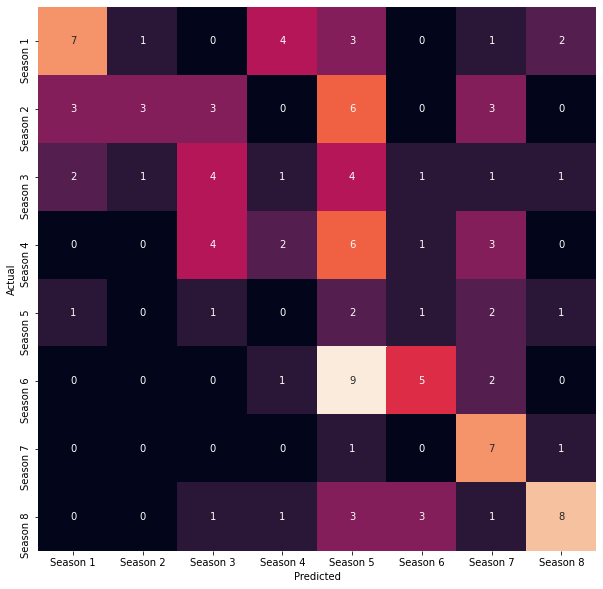

In [219]:
y_test = pd.Series(y_test)
plot_cm(y_test, y_pred, "LRM_ConfusionMatrix.png",normalized=False)

AttributeError: 'str' object has no attribute 'to_csv'